# Laboratory 5: PCA, Autoencoders


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from pyod.models.pca import PCA
import matplotlib.pyplot as plt
from pyod.models.kpca import KPCA
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



## Exercises

### EX 1
#### 1

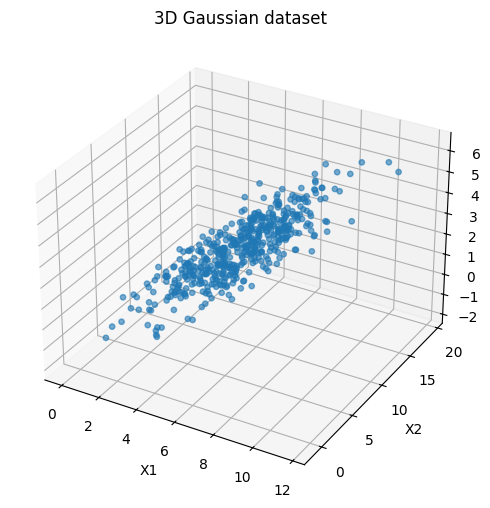

In [4]:
mean = np.array([5, 10, 2])
cov = np.array([[3, 2, 2], [2, 10, 1], [2, 1, 2]])

X = np.random.multivariate_normal(mean, cov, 500)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=15, alpha=0.6)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('3D Gaussian dataset')

plt.show()

mean_X = np.mean(X, axis=0)
X_centered = X - mean_X

N = X_centered.shape[0]
cov_matrix = (X_centered.T @ X_centered) / N

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


#### 2

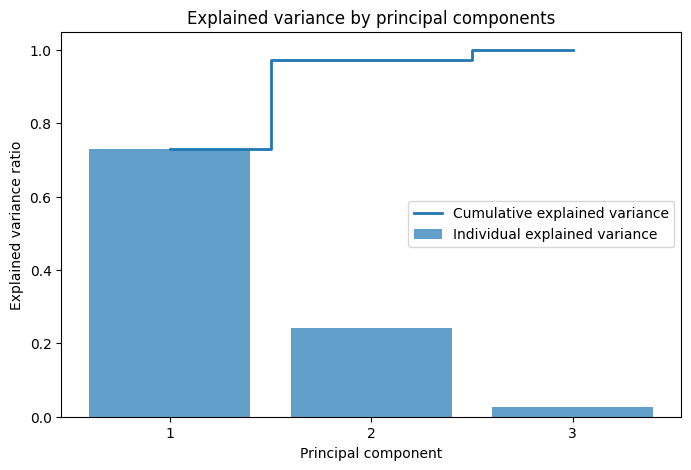

In [5]:
explained_variance = eigenvalues
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))

components = np.arange(1, len(explained_variance) + 1)

plt.bar(components,
        explained_variance_ratio,
        alpha=0.7,
        label='Individual explained variance')

plt.step(components,
         cumulative_variance,
         where='mid',
         linewidth=2,
         label='Cumulative explained variance')

plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.xticks(components)
plt.ylim(0, 1.05)
plt.legend()
plt.title('Explained variance by principal components')

plt.show()



#### 3

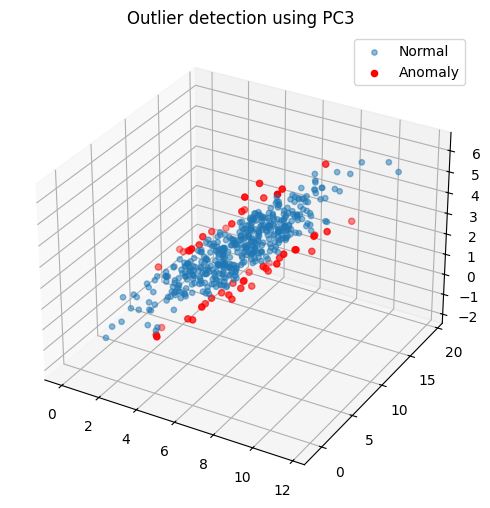

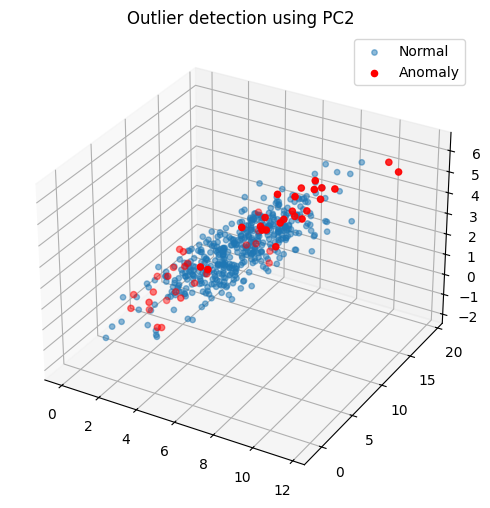

In [6]:
X_pca = X_centered @ eigenvectors
pc3 = X_pca[:, 2]
pc3_mean = np.mean(pc3)
deviation_pc3 = np.abs(pc3 - pc3_mean)

contamination = 0.1
threshold_pc3 = np.quantile(deviation_pc3, 1 - contamination)

labels_pc3 = deviation_pc3 > threshold_pc3

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[~labels_pc3, 0],
           X[~labels_pc3, 1],
           X[~labels_pc3, 2],
           s=15, alpha=0.5, label='Normal')

ax.scatter(X[labels_pc3, 0],
           X[labels_pc3, 1],
           X[labels_pc3, 2],
           s=20, color='red', label='Anomaly')

ax.set_title('Outlier detection using PC3')
ax.legend()
plt.show()

pc2 = X_pca[:, 1]
pc2_mean = np.mean(pc2)

deviation_pc2 = np.abs(pc2 - pc2_mean)

threshold_pc2 = np.quantile(deviation_pc2, 1 - contamination)
labels_pc2 = deviation_pc2 > threshold_pc2

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[~labels_pc2, 0],
           X[~labels_pc2, 1],
           X[~labels_pc2, 2],
           s=15, alpha=0.5, label='Normal')

ax.scatter(X[labels_pc2, 0],
           X[labels_pc2, 1],
           X[labels_pc2, 2],
           s=20, color='red', label='Anomaly')

ax.set_title('Outlier detection using PC2')
ax.legend()
plt.show()


#### 4

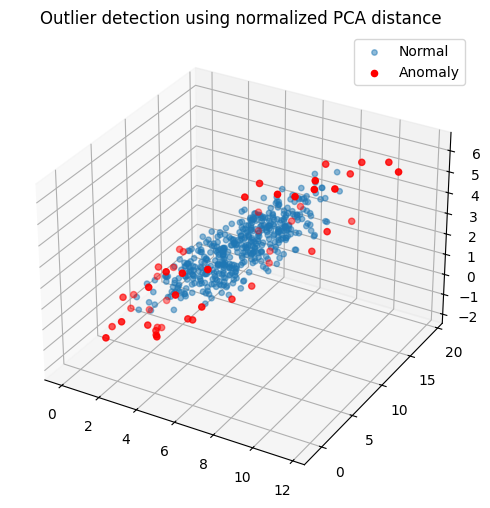

In [7]:
std_pca = np.sqrt(eigenvalues)
X_pca_normalized = X_pca / std_pca

centroid = np.mean(X_pca_normalized, axis=0)
scores = np.sum((X_pca_normalized - centroid) ** 2, axis=1)

contamination = 0.1
threshold = np.quantile(scores, 1 - contamination)

labels = scores > threshold
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[~labels, 0],
           X[~labels, 1],
           X[~labels, 2],
           s=15, alpha=0.5, label='Normal')

ax.scatter(X[labels, 0],
           X[labels, 1],
           X[labels, 2],
           s=20, color='red', label='Anomaly')

ax.set_title('Outlier detection using normalized PCA distance')
ax.legend()
plt.show()

### EX 2

#### 1

Training contamination rate: 0.07152556181682396


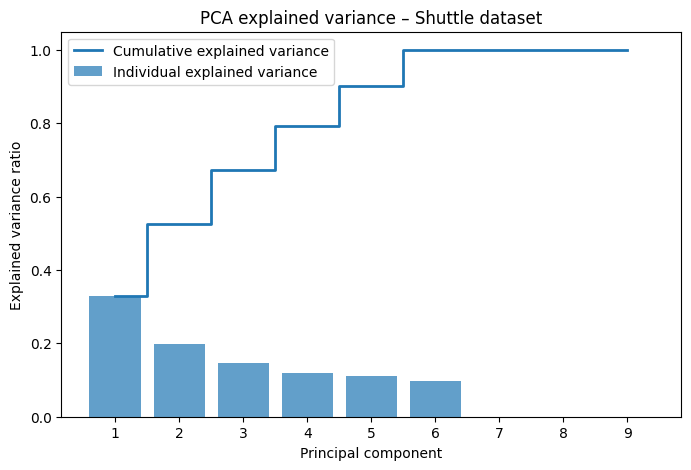

In [10]:
data = loadmat('./shuttle.mat')
X = data['X']
y = data['y'].ravel()


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.6,
    random_state=42,
    stratify=y
)
contamination = np.mean(y_train)
print("Training contamination rate:", contamination)

X_train_std, X_test_std = standardizer(X_train, X_test)
pca_model = PCA(contamination=contamination)
pca_model.fit(X_train_std)

explained_variance = pca_model.explained_variance_
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumulative_variance = np.cumsum(explained_variance_ratio)

components = np.arange(1, len(explained_variance) + 1)

plt.figure(figsize=(8, 5))

plt.bar(components,
        explained_variance_ratio,
        alpha=0.7,
        label='Individual explained variance')

plt.step(components,
         cumulative_variance,
         where='mid',
         linewidth=2,
         label='Cumulative explained variance')

plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('PCA explained variance – Shuttle dataset')
plt.xticks(components)
plt.ylim(0, 1.05)
plt.legend()
plt.show()


#### 2

In [12]:
y_train_pred_pca = pca_model.predict(X_train_std)
y_test_pred_pca  = pca_model.predict(X_test_std)

ba_train_pca = balanced_accuracy_score(y_train, y_train_pred_pca)
ba_test_pca  = balanced_accuracy_score(y_test, y_test_pred_pca)

print("PCA balanced accuracy (train):", ba_train_pca)
print("PCA balanced accuracy (test): ", ba_test_pca)

kpca_model = KPCA(
    contamination=contamination,
    kernel='rbf'
)

kpca_model.fit(X_train_std)

y_train_pred_kpca = kpca_model.predict(X_train_std)
y_test_pred_kpca  = kpca_model.predict(X_test_std)

ba_train_kpca = balanced_accuracy_score(y_train, y_train_pred_kpca)
ba_test_kpca  = balanced_accuracy_score(y_test, y_test_pred_kpca)

print("KPCA balanced accuracy (train):", ba_train_kpca)
print("KPCA balanced accuracy (test): ", ba_test_kpca)

print(f"PCA  - train: {ba_train_pca:.4f}, test: {ba_test_pca:.4f}")
print(f"KPCA - train: {ba_train_kpca:.4f}, test: {ba_test_kpca:.4f}")


PCA balanced accuracy (train): 0.9752082461478256
PCA balanced accuracy (test):  0.9708779881524603


KeyboardInterrupt: 

### Ex 3

#### 1

In [14]:
data = loadmat('shuttle.mat')

X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    random_state=42,
    stratify=y
)


scaler = MinMaxScaler(feature_range=(0, 1))

X_train_norm = scaler.fit_transform(X_train)
X_test_norm  = scaler.transform(X_test)

print("Train min:", X_train_norm.min(), "max:", X_train_norm.max())
print("Test  min:", X_test_norm.min(),  "max:", X_test_norm.max())



Train min: 0.0 max: 1.0000000000000002
Test  min: -0.020311372306423325 max: 0.9934640522875817


#### 2

In [ ]:
class Autoencoder(keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = keras.Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(5, activation='relu'),
            layers.Dense(3, activation='relu')
        ])

        self.decoder = keras.Sequential([
            layers.Dense(5, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(9, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = Autoencoder()

autoencoder.build(input_shape=(None, X_train_norm.shape[1]))
autoencoder.summary()

#### 3

In [ ]:
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

history = autoencoder.fit(
    X_train_norm,
    X_train_norm,
    epochs=100,
    batch_size=1024,
    shuffle=True,
    validation_data=(X_test_norm, X_test_norm),
    verbose=1
)
plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Autoencoder training and validation loss')
plt.legend()
plt.grid(True)
plt.show()


#### 4

In [ ]:
X_train_recon = autoencoder.predict(X_train_norm)

train_errors = np.mean(
    (X_train_norm - X_train_recon) ** 2,
    axis=1
)
contamination = np.mean(y_train)
print("Contamination rate:", contamination)

threshold = np.quantile(train_errors, 1 - contamination)
print("Reconstruction threshold:", threshold)

y_train_pred = train_errors > threshold

X_test_recon = autoencoder.predict(X_test_norm)

test_errors = np.mean(
    (X_test_norm - X_test_recon) ** 2,
    axis=1
)

y_test_pred = test_errors > threshold


ba_train = balanced_accuracy_score(y_train, y_train_pred)
ba_test = balanced_accuracy_score(y_test, y_test_pred)

print("Balanced accuracy (train):", ba_train)
print("Balanced accuracy (test): ", ba_test)


### Ex 4

#### 1

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0
noise_factor = 0.35

noise_train = tf.random.normal(shape=X_train.shape) * noise_factor
noise_test  = tf.random.normal(shape=X_test.shape) * noise_factor

X_train_noisy = X_train + noise_train
X_test_noisy  = X_test + noise_test

X_train_noisy = tf.clip_by_value(X_train_noisy, 0.0, 1.0)
X_test_noisy  = tf.clip_by_value(X_test_noisy, 0.0, 1.0)
print("Original train min/max:", X_train.min(), X_train.max())
print("Noisy train min/max:   ", tf.reduce_min(X_train_noisy).numpy(),
                                   tf.reduce_max(X_train_noisy).numpy())


#### 2

In [ ]:
class ConvAutoencoder(keras.Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = keras.Sequential([
            layers.Conv2D(
                filters=8,
                kernel_size=(3, 3),
                activation='relu',
                strides=2,
                padding='same'
            ),
            layers.Conv2D(
                filters=4,
                kernel_size=(3, 3),
                activation='relu',
                strides=2,
                padding='same'
            )
        ])

        self.decoder = keras.Sequential([
            layers.Conv2DTranspose(
                filters=4,
                kernel_size=(3, 3),
                activation='relu',
                strides=2,
                padding='same'
            ),
            layers.Conv2DTranspose(
                filters=8,
                kernel_size=(3, 3),
                activation='relu',
                strides=2,
                padding='same'
            ),
            layers.Conv2D(
                filters=1,
                kernel_size=(3, 3),
                activation='sigmoid',
                padding='same'
            )
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

conv_autoencoder = ConvAutoencoder()
conv_autoencoder.build(input_shape=(None, 28, 28, 1))
conv_autoencoder.summary()



#### 3

In [ ]:
X_train_cnn = X_train[..., tf.newaxis]
X_test_cnn = X_test[..., tf.newaxis]
X_test_noisy_cnn = X_test_noisy[..., tf.newaxis]

conv_autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

history = conv_autoencoder.fit(
    X_train_cnn, X_train_cnn,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test_cnn, X_test_cnn),
    verbose=1
)

X_train_recon = conv_autoencoder.predict(X_train_cnn)

train_errors = np.mean(
    (X_train_cnn - X_train_recon) ** 2,
    axis=(1, 2, 3)
)
threshold = np.mean(train_errors) + np.std(train_errors)
print("Reconstruction threshold:", threshold)

X_test_recon = conv_autoencoder.predict(X_test_cnn)

test_errors = np.mean(
    (X_test_cnn - X_test_recon) ** 2,
    axis=(1, 2, 3)
)


test_pred = test_errors > threshold

accuracy_original = np.mean(test_pred == 0)
print("acc on original images", accuracy_original)

X_test_noisy_recon = conv_autoencoder.predict(X_test_noisy_cnn)

noisy_errors = np.mean(
    (X_test_noisy_cnn - X_test_noisy_recon) ** 2,
    axis=(1, 2, 3)
)

noisy_pred = noisy_errors > threshold
accuracy_noisy = np.mean(noisy_pred == 1)
print("acc on noisy images:", accuracy_noisy)


#### 4

In [ ]:
n_images = 5
idx = np.random.choice(len(X_test), n_images, replace=False)

plt.figure(figsize=(12, 8))

for i, index in enumerate(idx):
    ax = plt.subplot(4, n_images, i + 1)
    plt.imshow(X_test[index], cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel('original', fontsize=12)

    ax = plt.subplot(4, n_images, i + 1 + n_images)
    plt.imshow(X_test_noisy[index], cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel('noisy', fontsize=12)

    ax = plt.subplot(4, n_images, i + 1 + 2 * n_images)
    plt.imshow(X_test_recon[index].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel('original', fontsize=12)

    ax = plt.subplot(4, n_images, i + 1 + 3 * n_images)
    plt.imshow(X_test_noisy_recon[index].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel('noisy', fontsize=12)

plt.tight_layout()
plt.show()
